In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('./preprocessed_dataset.csv')
df

,age,gender,cholesterol,systolic_bp,diastolic_bp,bmi,smoker,diabetes,heart_disease
0,68.0,0,209.164956,97.117122,74.713833,28.508402,0.0,0.0,0.0
1,58.0,1,176.503005,109.621379,85.863640,26.882949,1.0,0.0,0.0
2,44.0,1,187.153327,119.316210,92.382831,31.504201,1.0,0.0,0.0
3,72.0,0,173.519662,123.650092,80.212716,26.794425,0.0,0.0,0.0
4,37.0,1,198.433023,116.381459,83.088330,20.607503,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
495,34.0,1,200.541726,121.135968,76.083514,32.525816,1.0,0.0,0.0
496,41.0,1,216.255029,122.715323,82.691269,21.830949,0.0,0.0,0.0
497,45.0,0,197.520603,100.547521,76.568077,29.758831,0.0,0.0,0.0
498,55.0,1,242.411418,125.995319,86.215719,24.988101,0.0,0.0,0.0


## Checking Class Imbalance

In [4]:
target_column = 'heart_disease'  # Replace with actual target column name

# Check unique class values
df[target_column].unique()


array([0., 1.])

In [5]:
class_counts = df[target_column].value_counts()
print(class_counts)


heart_disease
0.0    350
1.0    150
Name: count, dtype: int64


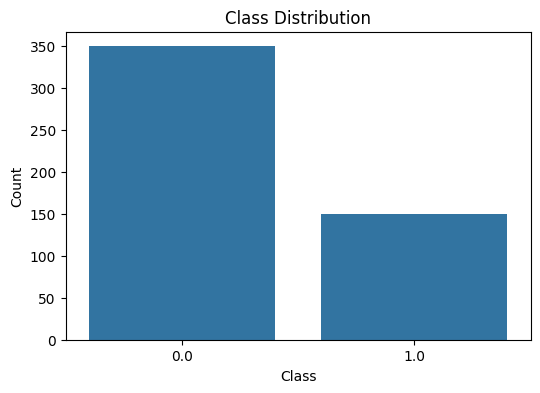

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x=df[target_column])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [7]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = df[target_column].unique()
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df[target_column])

class_weights = dict(zip(classes, weights))
print(class_weights)


{np.float64(0.0): np.float64(0.7142857142857143), np.float64(1.0): np.float64(1.6666666666666667)}


In [8]:
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")


Imbalance Ratio: 2.33


## Normalizing Numeric Features And Smote application

In [12]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Identify features (X) and target variable (y)
X = df.drop(columns=['heart_disease'])  # Independent variables
y = df['heart_disease']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Normalize numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the new class distribution after SMOTE
print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", pd.Series(y_train_resampled).value_counts())

Before SMOTE:
 heart_disease
0.0    280
1.0    120
Name: count, dtype: int64
After SMOTE:
 heart_disease
1.0    280
0.0    280
Name: count, dtype: int64


dict_keys(['0.0', '1.0', 'accuracy', 'macro avg', 'weighted avg'])
Model: RandomForest

              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87        70
         1.0       0.70      0.70      0.70        30

    accuracy                           0.82       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.82      0.82      0.82       100



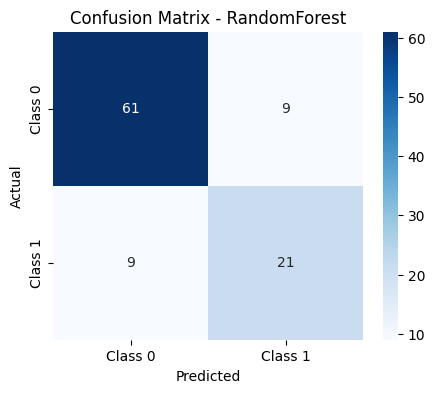

dict_keys(['0.0', '1.0', 'accuracy', 'macro avg', 'weighted avg'])
Model: XGBoost

              precision    recall  f1-score   support

         0.0       0.89      0.77      0.82        70
         1.0       0.59      0.77      0.67        30

    accuracy                           0.77       100
   macro avg       0.74      0.77      0.75       100
weighted avg       0.80      0.77      0.78       100



C:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


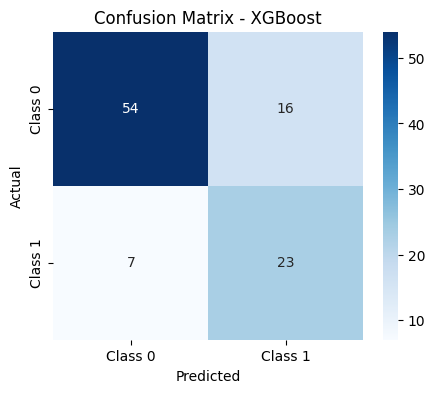

dict_keys(['0.0', '1.0', 'accuracy', 'macro avg', 'weighted avg'])
Model: LogisticRegression

              precision    recall  f1-score   support

         0.0       0.93      0.76      0.83        70
         1.0       0.60      0.87      0.71        30

    accuracy                           0.79       100
   macro avg       0.77      0.81      0.77       100
weighted avg       0.83      0.79      0.80       100



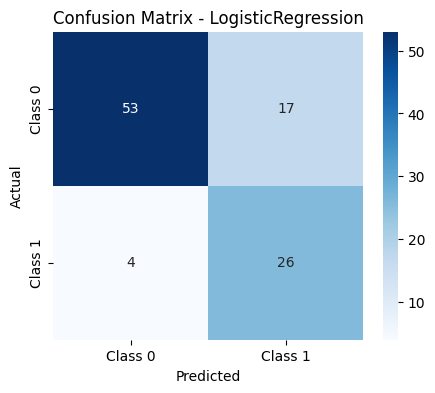

,Model,Accuracy,AUC-ROC,Precision,Recall,F1-score
0,RandomForest,0.82,0.872381,0.700000,0.700000,0.700000
1,XGBoost,0.77,0.837143,0.589744,0.766667,0.666667
2,LogisticRegression,0.79,0.884762,0.604651,0.866667,0.712329


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Define models
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42)
}

# Train and evaluate models
results = []
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # For AUC-ROC
    
    # Compute metrics
    acc = np.mean(y_pred == y_test)
    auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    print(report.keys())
    # Save results
    results.append({
        "Model": name,
        "Accuracy": acc,
        "AUC-ROC": auc,
        "Precision": report["1.0"]["precision"],
        "Recall": report["1.0"]["recall"],
        "F1-score": report["1.0"]["f1-score"]
    })

    # Print Classification Report
    print(f"Model: {name}\n")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df